In [1]:
import model
import numpy as np
import random
import tank
import truck

import gym_pdsystem

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import animation, rc
import matplotlib.patches as mpatches

from IPython.display import HTML

import pandas as pd
import time

from gym_pdsystem.envs.pdsystem_env import PDSystemEnv
import gym_pdsystem.utils.utilsq as ut
import gym_pdsystem.utils.constants as ct
import gym_pdsystem.utils.functions as fnc

import os

simulations_directory = './simulations'
if not os.path.exists(simulations_directory):
    os.makedirs(simulations_directory)


In [2]:
COEFF = ct.COEFF

C_TRANSPORT = ct.C_TRANSPORT
C_LEVELS = ct.C_LEVELS

p0_GLOBAL = ct.p0_GLOBAL

P1_GLOBAL = ct.P1_GLOBAL
P2_GLOBAL = ct.P2_GLOBAL

M_GLOBAL = ct.M_GLOBAL

NOT_DELIVERYING_PENALTY = P2_GLOBAL #to be equivalent/same importance as having 0 stock or surpassing max capacity levels


## System initializer

In [3]:
def initialize_test_system(seed = None):
    if seed != None:
        np.random.seed(seed)

    # Tanks' information
    global n
    n = 5 
    tank_ids = list(range(1,n+1))
    tank_max_loads =  np.array([100., 200, 100., 800., 200.])
    C_max = np.array([ [load] for load in tank_max_loads ])

    tank_current_loads = np.full(n,0)
    tank_consumption_rates =  np.array([5.] * n)
    noisy_consumption_rate = False
    
    global n_discrete_load_levels
    n_discrete_load_levels = np.array([4,4,4,4,4])
    
    load_level_percentages = np.array([ #b , c, e
                                            [0.02, 0.31, 0.9],
                                            [0.01, 0.03, 0.9],
                                            [0.05, 0.16, 0.9],
                                            [0.07, 0.14, 0.85],
                                            [0.08, 0.26, 0.9]
                                               ])
    for i in range(n):
        tank_consumption_rates[i] = tank_max_loads[i] * (load_level_percentages[i][0] + load_level_percentages[i][1])/2.0
        
    tank_levels = np.multiply(C_max,load_level_percentages)
    
    for i, tank_level in enumerate(tank_levels):
                a = tank_level[0]
                b = tank_level[-1]
                #current_load = 0.75 * (a+b)/2.0# np.random.randint(a+1,b, size =(1,)) GIVES A STRANGE ERROR
                current_load = np.random.random() * (b - a-1) + a+1 #np.random.randint(a+1,b)
                tank_current_loads[i] = current_load * 1.0
                
#     for i, (lvl, max_load) in enumerate(zip(n_discrete_load_levels, tank_max_loads)):
#         a = np.linspace(0,max_load, lvl+1)[1]
#         current_load = np.random.randint(a+1,max_load)
#         tank_current_loads[i] = current_load     

    # Trucks' information
    global k
    k = 2
    truck_ids = list(range(k))
    truck_max_loads = np.array([70.,130.])
    truck_current_loads = truck_max_loads.copy()
    truck_current_positions =  np.array([5] * k)
    #truck_fractions_deliverable =  np.array([1.] * k) # we for now we only allow to deliver all the content of the truck
    truck_fractions_deliverable =  np.array([ np.array([1.]), 
                                              np.array([1.])
                                            ]) # we for now we only allow to deliver all the content of the truck
    global n_discrete_load_levels_trucks
    n_discrete_load_levels_trucks = np.array([1,1])

    # System's information
   
    graph = ut.simple_graph(n+1)
    tanks = [tank.Tank( tank_id, current_load, max_load, consumption_rate, n_lvls, d_lvls, noisy_consumption_rate) 
             for  tank_id, current_load, max_load, consumption_rate, n_lvls, d_lvls in 
             zip( tank_ids, tank_current_loads, tank_max_loads, tank_consumption_rates, n_discrete_load_levels,
                  load_level_percentages)]
    trucks = [truck.Truck( truck_id, current_load, max_load, current_position, load_fractions_deliverable, n_lvls) 
             for  truck_id, current_load, max_load, current_position, load_fractions_deliverable, n_lvls in 
             zip(truck_ids, truck_current_loads, truck_max_loads, truck_current_positions, 
                 truck_fractions_deliverable, n_discrete_load_levels_trucks)]

    w =  np.array([32., 159., 162., 156.,156., 0.])

    weights_matrix = ut.simple_weights(n+1, w)
    
    return(tanks, trucks, graph, weights_matrix)

tanks, trucks, graph, weights_matrix = initialize_test_system()
toy_system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)

# Action-State space dimension
a_s_dim = toy_system.states_dim * toy_system.actions_dim
a_s_dim

368640

In [4]:
tanks, trucks, graph, weights_matrix = initialize_test_system(seed = 42)
system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)
print(system.tank_loads())
print(system.graph)
print(system.weights)

[35, 171, 67, 429, 42]
[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [1 1 1 1 1 1]]
[[ inf  inf  inf  inf  inf  inf]
 [ inf  inf  inf  inf  inf  inf]
 [ inf  inf  inf  inf  inf  inf]
 [ inf  inf  inf  inf  inf  inf]
 [ inf  inf  inf  inf  inf  inf]
 [ 32. 159. 162. 156. 156.   0.]]


### Reinitialize system function

In [5]:
def reinitialize_system(system, seed = None):
    if seed != None:
        np.random.seed(seed)
        
    for tank, tank_levels in zip(system.tanks, system.tanks_level):
        a = tank_levels[0]
        b = tank_levels[-1]
        current_load = np.random.random() * (b - a-1) + a+1 #np.random.randint(a+1,b)*1.0
        tank.load = current_load
    system.reset_trucks_positions(); 
    return(system)    

## Q-learning algorithm (off-policy)


### Training

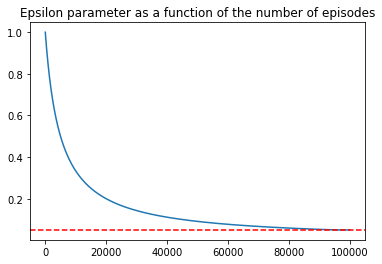

In [6]:
# Retrain parameters:
retrain = False

episode_retrain = 2*10**3 # episode number from which start the retrain. Ensure that a file with this number in 
                          # the Q filename is available.
retrain_episodes = 1*10**3


# Train parameters:
train_epsilon = True

learning_rate0 = 1 
learning_rate_decay = 0 

episode_length = 30
discount_rate = 0.9

episodes = 1*10**5
episodes_epsilon_min = 0.05*episodes

# Output's frequencies
train_freq = 10**2 # 10**4
train_vis_freq =  np.inf #10**3
train_rew_freq =  10**2
train_Q_freq =  10**3

epsilon0 = 1.0
epsilon_decay =( 1./(episodes_epsilon_min) ) 
epsilon_min = 0.05

verbose = False
verbose_info = False

seed = 42

simulation_id = 21

# Visualization of the epsilon parameter value that will be present duing the simulation
% matplotlib inline

def epsilon_fnc(x, epsilon0 = epsilon0, decay = epsilon_decay, epsilon_min = epsilon_min):
    e_mins = epsilon_min * np.ones(len(x))
    eps = epsilon0 / (1.0 + (x-1)*epsilon_decay)
    return np.maximum(e_mins, eps )

t = np.arange(1, episodes, 1)
epsilon = epsilon_fnc(t)

plt.plot(t, epsilon)
plt.axhline(y= epsilon_min, xmin=0, xmax=episodes, hold=None, color = "Red", linestyle = '--')

plt.title("Epsilon parameter as a function of the number of episodes");

In [7]:
train_visualization_steps = []
train_rewards_list = []

tanks, trucks, graph, weights_matrix = initialize_test_system()
toy_system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)

Q = {}

# Create directories for the simulations' outputs

simulation_directory = './simulations/simulation{}'.format(simulation_id)
rewards_file = simulation_directory+'/discrewards'+ '/rewards-sim{}.csv'.format(simulation_id)
states_file = simulation_directory+'/vis'+ '/states-sim{}.csv'.format(simulation_id) # for testing

if not os.path.exists(simulation_directory):
    os.makedirs(simulation_directory)
    os.makedirs(simulation_directory + '/Q-dictionaries')
    os.makedirs(simulation_directory + '/discrewards')
    os.makedirs(simulation_directory + '/vis')
    
else:
    raise Exception("The simulation id you tried to use has been already used before. Try to change it to a new one.")

    
ut.save_obj(toy_system, simulation_directory+"/system-sim"+f"{simulation_id}") 

# Output headers to file
with open(rewards_file,'w') as f:
     np.savetxt(f, [["episode", "discreward"]], fmt="%s", delimiter=',')         


In [8]:
def episodic_train_Q_epsilon( 
            epsilon0 = epsilon0,
            epsilon_min = epsilon_min,
            n_episodes = episodes, 
            episode_length = episode_length,
            learning_rate0 = learning_rate0,
            learning_rate_decay = learning_rate_decay,
            discount_rate = discount_rate,
            system = toy_system,
            Q = Q, verbose = verbose, verbose_info = verbose_info,
            visualization_steps = train_visualization_steps, rewards_list = train_rewards_list,
            seed = seed, 
            freq = train_freq,
            vis_freq = train_vis_freq,
            rew_freq = train_rew_freq,
            Q_freq = train_Q_freq,
            simulation_id = simulation_id,
            round_time = 2
    
           ):
    
    time_start = time.time()
    
    for episode in range(1,n_episodes+1):
        print("\rEpisode: {}".format(episode), end="")

        reinitialize_system(system, seed = episode)
        
        ### epsilon-greedy exploration
        epsilon = max( epsilon_min, epsilon0 / (1+(episode-1)*epsilon_decay) ) 
        
        ### decrement of learning rate
        learning_rate = learning_rate0 / (1+(episode-1)*learning_rate_decay)        

        discounted_reward = 0
        
        for t in range(episode_length):

            system.update_state()
            s_current = system.state_to_string()                
            p = np.random.uniform()

            if p > epsilon:
                #DETERMINISTIC ACTION OPTIMAL
                s0 = system.state_to_string()
                best_action = optimal_policy(s0, Q)
                if best_action == None:
                    reward, _,_ = system.random_action(seed = (seed + (t+1)*episode), verbose = verbose)
                else:
                    reward, _ ,_ = system.deterministic_action(best_action)
                #print(best_action)
            else:
                reward,_ ,_ = system.random_action(seed = (seed + (t+1)*episode), verbose = verbose)

            a_current = system.action_to_string()
            sa_current = ''.join([s_current, a_current])

            system.update_state()
            sa_new = system.state_action_to_string()

            if ut.is_key(Q, sa_current) == False:
                Q[sa_current] = 0

            Q_max = max([Q[key] for key in Q.keys() if key.startswith(sa_new[0:system.state_length])]+[0.0]) 

            if Q[sa_current] != -np.inf:
                Q[sa_current] = ( (1-learning_rate) * Q[sa_current] 
                                 + learning_rate* (reward + discount_rate * Q_max)
                                )
                
            discounted_reward = discounted_reward + (discount_rate**t) * reward
            system.reset_trucks_positions();     
            system.reset_trucks_loads();
            
        #rewards_list.append(discounted_reward);
        if episode % freq == 0:
                time_end = time.time()
                print(". Elapsed time ", round( (time_end-time_start)/60., round_time), " minuts.",
                      "epsilon", round(epsilon,4), 
                     "Discounted reward: ", discounted_reward)
                
                if verbose_info:
                    print("s, a", system.s, system.a)
                    print("ds, da", system.ds, system.da)
        if episode % Q_freq == 0:           
                ut.save_obj(Q, simulation_directory +"/Q-dictionaries/Q-dict-sim" + f"{simulation_id}" + "-" + f"{episode}")   

        if episode % vis_freq == 0:
                #Save visualization and rewards
                visualization_steps.append(toy_system.visualize());
                ut.save_obj(visualization_steps, simulation_directory +"/vis/vis-train-sim" + f"{simulation_id}" + "-" + f"{episode}")   
                                
        if episode % rew_freq == 0:
                #rewards_list.append(discounted_reward);
                #ut.save_obj(rewards_list, simulation_directory +"/discrewards/discrew-train-sim" + f"{simulation_id}" + "-" + f"{episode}")
                # Output data to files
                with open(rewards_file,'ab') as f:
                    np.savetxt(f, [np.array([episode, discounted_reward])], fmt=("%d",'%.10f'), delimiter=',')    
        
    end_time = round(time.time()-time_start,round_time)        
    print(f"Training finished. Total episodes: {n_episodes}. Elapsed time: {round(end_time/60., round_time)} minutes.")        

In [9]:
# Given a state, returns the action that has the highest Q-value.

def optimal_policy(state, Q, system = toy_system):
    """
    state must be in the string-integers code
    """
    state_keys = [key for key in list(Q) if key.startswith(state)]
    if len(state_keys) == 0:
        return(None)
    
    state_q = [Q[state_key] for state_key in state_keys]
    
    #print("state_q ", state_q[1:min(10,len(state_q))])
    
    max_q = max(state_q)
    #print("max_q", max_q)
    optimal_key_index = np.where(np.isin(state_q, max_q ))[0][0]
    #print("optimal_key_index", optimal_key_index)
    optimal_key = state_keys[optimal_key_index]
    #print("optimal_key", optimal_key)
    optimal_action = optimal_key[system.state_length:]
    
    return(optimal_action)
    

In [10]:
if train_epsilon == True and retrain == False:
    episodic_train_Q_epsilon()
elif train_epsilon == False and retrain == True:
    Q_retrain = ut.load_obj(simulation_directory + "/Q-dictionaries/Q-dict-sim" + f"{simulation_id}" + "-" + f"{episode_retrain}")
    episodic_train_Q_epsilon(n_episodes = retrain_episodes, Q = Q_retrain)
else:
    raise Exception("Only one of the parameters train_epsilon or retrain parameters can be set to True.")
    
    

Episode: 100. Elapsed time  0.05  minuts. epsilon 0.9806 Discounted reward:  -532.3765339650489
Episode: 200. Elapsed time  0.12  minuts. epsilon 0.9617 Discounted reward:  -560.2954893539198
Episode: 300. Elapsed time  0.19  minuts. epsilon 0.9436 Discounted reward:  -502.6412850566616
Episode: 400. Elapsed time  0.27  minuts. epsilon 0.9261 Discounted reward:  -720.9703774056161
Episode: 500. Elapsed time  0.36  minuts. epsilon 0.9093 Discounted reward:  -443.67641992463064
Episode: 600. Elapsed time  0.46  minuts. epsilon 0.893 Discounted reward:  -347.5394315433778
Episode: 700. Elapsed time  0.56  minuts. epsilon 0.8773 Discounted reward:  -427.4880513231186
Episode: 800. Elapsed time  0.68  minuts. epsilon 0.8622 Discounted reward:  -646.8612048035602
Episode: 900. Elapsed time  0.8  minuts. epsilon 0.8476 Discounted reward:  -537.9549756951512
Episode: 1000. Elapsed time  0.92  minuts. epsilon 0.8335 Discounted reward:  -413.5476049740735
Episode: 1100. Elapsed time  1.04  minut

Episode: 8600. Elapsed time  19.53  minuts. epsilon 0.3677 Discounted reward:  -266.99139334256427
Episode: 8700. Elapsed time  19.81  minuts. epsilon 0.365 Discounted reward:  -284.8410704585242
Episode: 8800. Elapsed time  20.1  minuts. epsilon 0.3623 Discounted reward:  -390.2051109885952
Episode: 8900. Elapsed time  20.39  minuts. epsilon 0.3597 Discounted reward:  -378.7443768893335
Episode: 9000. Elapsed time  20.73  minuts. epsilon 0.3572 Discounted reward:  -146.1279871461263
Episode: 9100. Elapsed time  21.03  minuts. epsilon 0.3546 Discounted reward:  -418.0722936200942
Episode: 9200. Elapsed time  21.35  minuts. epsilon 0.3521 Discounted reward:  -495.9595811722343
Episode: 9300. Elapsed time  21.7  minuts. epsilon 0.3497 Discounted reward:  -370.0636057325069
Episode: 9400. Elapsed time  22.03  minuts. epsilon 0.3472 Discounted reward:  -454.26567134839655
Episode: 9500. Elapsed time  22.36  minuts. epsilon 0.3449 Discounted reward:  -71.17361777628668
Episode: 9600. Elapse

Episode: 16900. Elapsed time  47.58  minuts. epsilon 0.2283 Discounted reward:  -120.30353692456711
Episode: 17000. Elapsed time  47.91  minuts. epsilon 0.2273 Discounted reward:  -148.72632380435707
Episode: 17100. Elapsed time  48.3  minuts. epsilon 0.2263 Discounted reward:  -139.44967566735525
Episode: 17200. Elapsed time  48.74  minuts. epsilon 0.2252 Discounted reward:  -150.54400312712252
Episode: 17300. Elapsed time  49.16  minuts. epsilon 0.2242 Discounted reward:  -118.95223285655663
Episode: 17400. Elapsed time  49.49  minuts. epsilon 0.2232 Discounted reward:  -158.80184442883163
Episode: 17500. Elapsed time  49.82  minuts. epsilon 0.2222 Discounted reward:  -235.14177698162408
Episode: 17600. Elapsed time  50.16  minuts. epsilon 0.2212 Discounted reward:  -183.249634510072
Episode: 17700. Elapsed time  50.5  minuts. epsilon 0.2203 Discounted reward:  -312.6890729243516
Episode: 17800. Elapsed time  50.85  minuts. epsilon 0.2193 Discounted reward:  -109.9570515898518
Episod

Episode: 25200. Elapsed time  79.22  minuts. epsilon 0.1656 Discounted reward:  -168.24100416205846
Episode: 25300. Elapsed time  79.61  minuts. epsilon 0.165 Discounted reward:  -58.0213681326627
Episode: 25400. Elapsed time  80.09  minuts. epsilon 0.1645 Discounted reward:  -37.732891318936474
Episode: 25500. Elapsed time  80.57  minuts. epsilon 0.1639 Discounted reward:  -163.00549955721408
Episode: 25600. Elapsed time  80.94  minuts. epsilon 0.1634 Discounted reward:  -284.7893622243083
Episode: 25700. Elapsed time  81.31  minuts. epsilon 0.1629 Discounted reward:  -49.49327596869853
Episode: 25800. Elapsed time  81.7  minuts. epsilon 0.1623 Discounted reward:  -230.53005103544007
Episode: 25900. Elapsed time  82.07  minuts. epsilon 0.1618 Discounted reward:  -106.59140424889989
Episode: 26000. Elapsed time  82.46  minuts. epsilon 0.1613 Discounted reward:  -91.15692996767751
Episode: 26100. Elapsed time  82.9  minuts. epsilon 0.1608 Discounted reward:  -54.92427199408422
Episode: 

Episode: 33500. Elapsed time  113.97  minuts. epsilon 0.1299 Discounted reward:  -93.36148200281322
Episode: 33600. Elapsed time  114.35  minuts. epsilon 0.1295 Discounted reward:  -98.44245247978596
Episode: 33700. Elapsed time  114.76  minuts. epsilon 0.1292 Discounted reward:  -257.79165158987576
Episode: 33800. Elapsed time  115.18  minuts. epsilon 0.1289 Discounted reward:  -80.42876608745037
Episode: 33900. Elapsed time  115.59  minuts. epsilon 0.1285 Discounted reward:  -207.45031067877176
Episode: 34000. Elapsed time  115.99  minuts. epsilon 0.1282 Discounted reward:  -264.63158415790963
Episode: 34100. Elapsed time  116.43  minuts. epsilon 0.1279 Discounted reward:  -147.3619454559971
Episode: 34200. Elapsed time  116.85  minuts. epsilon 0.1276 Discounted reward:  -148.01527268751443
Episode: 34300. Elapsed time  117.23  minuts. epsilon 0.1272 Discounted reward:  -34.75516027474686
Episode: 34400. Elapsed time  117.65  minuts. epsilon 0.1269 Discounted reward:  -116.3319994668

Episode: 41700. Elapsed time  149.06  minuts. epsilon 0.1071 Discounted reward:  -144.8215623768514
Episode: 41800. Elapsed time  149.46  minuts. epsilon 0.1068 Discounted reward:  -93.55382430258875
Episode: 41900. Elapsed time  149.86  minuts. epsilon 0.1066 Discounted reward:  -83.5671195724811
Episode: 42000. Elapsed time  150.26  minuts. epsilon 0.1064 Discounted reward:  -116.31487696975285
Episode: 42100. Elapsed time  150.7  minuts. epsilon 0.1062 Discounted reward:  -30.316924808693933
Episode: 42200. Elapsed time  151.12  minuts. epsilon 0.1059 Discounted reward:  -193.22080218938183
Episode: 42300. Elapsed time  151.54  minuts. epsilon 0.1057 Discounted reward:  -135.13080112604803
Episode: 42400. Elapsed time  151.96  minuts. epsilon 0.1055 Discounted reward:  -147.419653011776
Episode: 42500. Elapsed time  152.42  minuts. epsilon 0.1053 Discounted reward:  -180.19714480176435
Episode: 42600. Elapsed time  152.81  minuts. epsilon 0.105 Discounted reward:  -180.4140629069367

Episode: 49900. Elapsed time  184.41  minuts. epsilon 0.0911 Discounted reward:  -141.84290091656305
Episode: 50000. Elapsed time  184.93  minuts. epsilon 0.0909 Discounted reward:  -22.717358998583375
Episode: 50100. Elapsed time  185.38  minuts. epsilon 0.0907 Discounted reward:  -68.45508217371315
Episode: 50200. Elapsed time  185.77  minuts. epsilon 0.0906 Discounted reward:  -75.9215382005936
Episode: 50300. Elapsed time  186.2  minuts. epsilon 0.0904 Discounted reward:  -28.086516134467747
Episode: 50400. Elapsed time  186.63  minuts. epsilon 0.0903 Discounted reward:  -98.64092996246839
Episode: 50500. Elapsed time  187.15  minuts. epsilon 0.0901 Discounted reward:  -58.86314541278878
Episode: 50600. Elapsed time  187.61  minuts. epsilon 0.0899 Discounted reward:  -191.18315999785796
Episode: 50700. Elapsed time  188.0  minuts. epsilon 0.0898 Discounted reward:  -72.00738971091852
Episode: 50800. Elapsed time  188.4  minuts. epsilon 0.0896 Discounted reward:  -148.321613135165
E

Episode: 58100. Elapsed time  220.37  minuts. epsilon 0.0792 Discounted reward:  -21.45318391088579
Episode: 58200. Elapsed time  220.9  minuts. epsilon 0.0791 Discounted reward:  -75.77651390237698
Episode: 58300. Elapsed time  221.36  minuts. epsilon 0.079 Discounted reward:  -166.69987354579473
Episode: 58400. Elapsed time  221.76  minuts. epsilon 0.0789 Discounted reward:  -73.11987491019025
Episode: 58500. Elapsed time  222.2  minuts. epsilon 0.0787 Discounted reward:  -40.39131462769276
Episode: 58600. Elapsed time  222.63  minuts. epsilon 0.0786 Discounted reward:  -147.9112881176352
Episode: 58700. Elapsed time  223.06  minuts. epsilon 0.0785 Discounted reward:  -122.59265677289568
Episode: 58800. Elapsed time  223.47  minuts. epsilon 0.0784 Discounted reward:  -25.265778074146304
Episode: 58900. Elapsed time  223.95  minuts. epsilon 0.0782 Discounted reward:  -25.041980849964283
Episode: 59000. Elapsed time  224.39  minuts. epsilon 0.0781 Discounted reward:  -287.6548856737652

Episode: 66300. Elapsed time  257.14  minuts. epsilon 0.0701 Discounted reward:  -29.849806868203647
Episode: 66400. Elapsed time  257.55  minuts. epsilon 0.07 Discounted reward:  -49.228067912692715
Episode: 66500. Elapsed time  258.0  minuts. epsilon 0.0699 Discounted reward:  -27.478712879524558
Episode: 66600. Elapsed time  258.46  minuts. epsilon 0.0698 Discounted reward:  -22.87252599236439
Episode: 66700. Elapsed time  258.99  minuts. epsilon 0.0697 Discounted reward:  -32.70186651257107
Episode: 66800. Elapsed time  259.42  minuts. epsilon 0.0696 Discounted reward:  -181.1453787274372
Episode: 66900. Elapsed time  259.88  minuts. epsilon 0.0695 Discounted reward:  -27.544022503573306
Episode: 67000. Elapsed time  260.33  minuts. epsilon 0.0694 Discounted reward:  -35.30255403837504
Episode: 67100. Elapsed time  260.75  minuts. epsilon 0.0693 Discounted reward:  -81.28959558355606
Episode: 67200. Elapsed time  261.16  minuts. epsilon 0.0693 Discounted reward:  -173.9945086128287

Episode: 74500. Elapsed time  294.02  minuts. epsilon 0.0629 Discounted reward:  -63.43405609517127
Episode: 74600. Elapsed time  294.43  minuts. epsilon 0.0628 Discounted reward:  -26.43499557233113
Episode: 74700. Elapsed time  294.87  minuts. epsilon 0.0627 Discounted reward:  -64.09546953358173
Episode: 74800. Elapsed time  295.28  minuts. epsilon 0.0627 Discounted reward:  -21.59721166663356
Episode: 74900. Elapsed time  295.7  minuts. epsilon 0.0626 Discounted reward:  -38.95040154120726
Episode: 75000. Elapsed time  296.11  minuts. epsilon 0.0625 Discounted reward:  -57.14221164688872
Episode: 75100. Elapsed time  296.57  minuts. epsilon 0.0624 Discounted reward:  -25.75236833049567
Episode: 75200. Elapsed time  297.09  minuts. epsilon 0.0623 Discounted reward:  -38.14585928307085
Episode: 75300. Elapsed time  297.5  minuts. epsilon 0.0623 Discounted reward:  -38.987928172099586
Episode: 75400. Elapsed time  298.02  minuts. epsilon 0.0622 Discounted reward:  -36.060384634021226


Episode: 82700. Elapsed time  330.59  minuts. epsilon 0.057 Discounted reward:  -48.53183756454845
Episode: 82800. Elapsed time  331.14  minuts. epsilon 0.0569 Discounted reward:  -112.40880047248997
Episode: 82900. Elapsed time  331.58  minuts. epsilon 0.0569 Discounted reward:  -124.71234903999144
Episode: 83000. Elapsed time  332.05  minuts. epsilon 0.0568 Discounted reward:  -32.41023493507498
Episode: 83100. Elapsed time  332.59  minuts. epsilon 0.0568 Discounted reward:  -60.64770873611051
Episode: 83200. Elapsed time  333.04  minuts. epsilon 0.0567 Discounted reward:  -39.92855449027175
Episode: 83300. Elapsed time  333.46  minuts. epsilon 0.0566 Discounted reward:  -121.8954888151074
Episode: 83400. Elapsed time  333.91  minuts. epsilon 0.0566 Discounted reward:  -27.74035846073739
Episode: 83500. Elapsed time  334.46  minuts. epsilon 0.0565 Discounted reward:  -51.91596437764702
Episode: 83600. Elapsed time  334.89  minuts. epsilon 0.0564 Discounted reward:  -31.30530038354437

Episode: 90900. Elapsed time  368.47  minuts. epsilon 0.0521 Discounted reward:  -49.86720187383321
Episode: 91000. Elapsed time  368.97  minuts. epsilon 0.0521 Discounted reward:  -30.823030015570637
Episode: 91100. Elapsed time  369.46  minuts. epsilon 0.052 Discounted reward:  -52.38841005730517
Episode: 91200. Elapsed time  369.92  minuts. epsilon 0.052 Discounted reward:  -23.843380940838408
Episode: 91300. Elapsed time  370.35  minuts. epsilon 0.0519 Discounted reward:  -74.09369367903346
Episode: 91400. Elapsed time  370.85  minuts. epsilon 0.0519 Discounted reward:  -58.597750323687784
Episode: 91500. Elapsed time  371.27  minuts. epsilon 0.0518 Discounted reward:  -33.758258263382295
Episode: 91600. Elapsed time  371.69  minuts. epsilon 0.0518 Discounted reward:  -24.68469764225503
Episode: 91700. Elapsed time  372.12  minuts. epsilon 0.0517 Discounted reward:  -26.91426673607935
Episode: 91800. Elapsed time  372.57  minuts. epsilon 0.0517 Discounted reward:  -155.119697187318

Episode: 99200. Elapsed time  406.39  minuts. epsilon 0.05 Discounted reward:  -50.78510963417618
Episode: 99300. Elapsed time  406.83  minuts. epsilon 0.05 Discounted reward:  -61.947873883156035
Episode: 99400. Elapsed time  407.25  minuts. epsilon 0.05 Discounted reward:  -20.156201779888
Episode: 99500. Elapsed time  407.68  minuts. epsilon 0.05 Discounted reward:  -47.072172459237024
Episode: 99600. Elapsed time  408.16  minuts. epsilon 0.05 Discounted reward:  -124.24701777959453
Episode: 99700. Elapsed time  408.61  minuts. epsilon 0.05 Discounted reward:  -33.48532182428585
Episode: 99800. Elapsed time  409.02  minuts. epsilon 0.05 Discounted reward:  -32.316108416737535
Episode: 99900. Elapsed time  409.45  minuts. epsilon 0.05 Discounted reward:  -23.87383826699046
Episode: 100000. Elapsed time  409.95  minuts. epsilon 0.05 Discounted reward:  -75.26980464520025
Training finished. Total episodes: 100000. Elapsed time: 409.95 minutes.


### Testing

In [11]:
# TEST PARAMETERS AND INITIALIZATION

# Initialize system
episodes = 100000#243000

tanks, trucks, graph, weights_matrix = initialize_test_system(seed =episodes+1)
test_toy_system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)

Q = ut.load_obj(simulation_directory + "/Q-dictionaries/Q-dict-sim" + f"{simulation_id}" + "-" + f"{episodes}")


test_episodes = 1
episode_length =30
test_freq = 1
test_verbose = False

test_visualization_steps = []
test_rewards_list = []
test_level_rewards_list = []
test_transport_rewards_list = []
test_trucks_sent_list = []

In [12]:
with open(states_file,'w') as f:
     np.savetxt(f, [["step", "stock0", "stock1", "stock2","stock3", "stock4"]], fmt="%s", delimiter=',')  


def test_Q(n_episodes = test_episodes, 
           episode_length = episode_length,
           system = test_toy_system,
           visualization_steps = test_visualization_steps, 
           rewards_list = test_rewards_list,
           level_rewards_list = test_level_rewards_list,
           transport_rewards_list = test_transport_rewards_list,
           trucks_sent_list = test_trucks_sent_list,
           freq = test_freq,
           test_verbose = test_verbose ,
           states_file = states_file, 
           Q = Q
          ):
    
    for episode in range(1,n_episodes+1): 
        print("\rTest episode: {}\n".format(episode), end="")
        reinitialize_system(system, seed = episode+episodes)

        discounted_reward = 0 
        transport_rewards = 0
        level_rewards = 0
        number_of_trucks_sent = 0
        
        for i in range(1,episode_length+1):
            #print("state", test_toy_system.s, test_toy_system.ds)
            system.update_state()

            #Save visualization steps
            if i % freq == 0:
                visualization_steps.append(system.visualize());
                state = system.state()
#                 print(state[2])
#                 print([i]+state[2])
                with open(states_file,'ab') as f:
                    np.savetxt(f, [np.array([(episode-1)*(episode_length)+i]+state[2])], fmt=("%d",'%.3f','%.3f','%.3f','%.3f','%.3f'), delimiter=',')    

            s0 = system.state_to_string()
            best_action = optimal_policy(s0, Q)
            #print("best_action", best_action)

            if best_action == None:
                reward, transport_reward, level_reward = system.random_action()
                if i % freq == 0:
                    if test_verbose == True:
                        print("Episode", episode, "t", i-1, round(reward,7), round(level_reward,7), round(transport_reward,7), "\nRandom action is performed. Current state unknown for Q.")

            else:
                reward, transport_reward, level_reward = system.deterministic_action(best_action)
                number_of_trucks_sent = number_of_trucks_sent + best_action.count('5')
                if i % freq == 0:
                    if test_verbose == True:
                        print("Episode", episode, "t",i-1,round(reward,7),round(level_reward,7), round(transport_reward,7), best_action)

            system.reset_trucks_positions();
            system.reset_trucks_loads();
            
            discounted_reward = discounted_reward + (discount_rate**(i-1)) * reward
            transport_rewards = transport_rewards+transport_reward
            level_rewards = level_rewards + level_reward
            
            if reward <= P2_GLOBAL:
                print("\rSome tank is in a forbidden level")

        system.reset_trucks_positions();
        
        #Save rewards
        if episode % freq == 0:
            rewards_list.append(discounted_reward);
            transport_rewards_list.append(transport_rewards);
            level_rewards_list.append(level_rewards);
            trucks_sent_list.append(episode_length * system.k - number_of_trucks_sent);





Test episode: 1


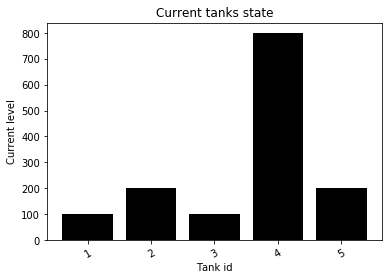

In [13]:
test_Q()
#print(np.mean(test_rewards_list) )

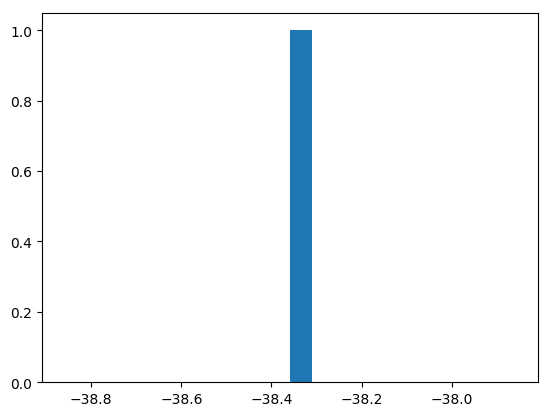

In [14]:
%matplotlib inline
mpl.rcParams.update(mpl.rcParamsDefault)
plt.hist(test_rewards_list, bins = 20)
plt.show()

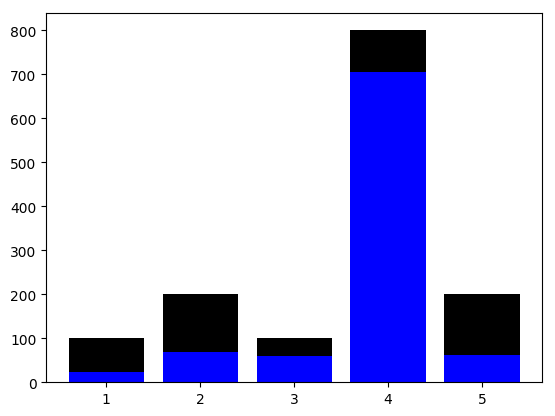

In [15]:
# Visualizing test simulation:

test_anim = ut.create_system_animation(test_visualization_steps, test_episodes * episode_length,test_freq)
HTML(test_anim.to_html5_video())


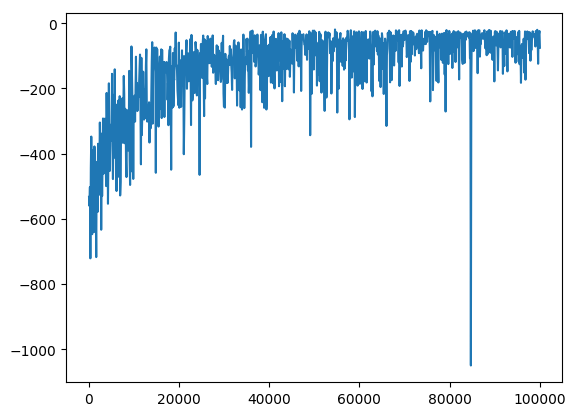

In [16]:
# Visualizing train simulation:

episode =episodes
#simulation_id = 2
step = 30
# discrewards_list = ut.load_obj(simulation_directory+"/discrewards/discrew-train-sim" + f"{simulation_id}" + "-" + f"{episode}")

# discrewards_list2 = [discrewards_list[i] for i in range(0,len(discrewards_list),step)]

# p = plt.plot([i for i in range(0,len(discrewards_list),step)], 
#              discrewards_list2)
# plt.savefig(simulation_directory+'/discrewards-sim' + f'{simulation_id}' + '.png')

discrewards = pd.read_table(rewards_file, sep = ",")

plt.plot(discrewards['episode'],discrewards['discreward'], label = "Discounted rewards")

plt.show()
plt.close()


In [17]:
len(list(Q))

25255

In [18]:
tank_levels = [test_visualization_steps[i][2] for i in range(len(test_visualization_steps))]
tank_levels_array = np.asarray(tank_levels).transpose()

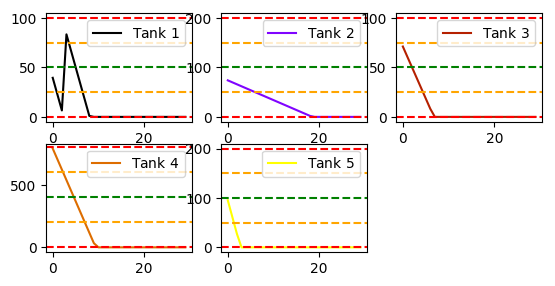

In [19]:
#DISCRETE LEVELS

cmap = plt.get_cmap('gnuplot')
colors = [cmap(i) for i in np.linspace(0, 1, n)]
lvl_colors = ["Orange", "Green","Orange"]

tanks = test_toy_system.tanks

for i, color in enumerate(colors, start=1):
    plt.subplot(3,3, i)    
    plt.plot(tank_levels_array[i-1], color=color, label='Tank ${i}$'.format(i=i))
    
    plt.axhline(y= tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = "Red", linestyle = '--')
    for lvl_color, lvl in zip(lvl_colors, tanks[i-1].levels):
        plt.axhline(y= lvl, xmin=0, xmax=episode_length, hold=None, color = lvl_color, linestyle = '--')
    plt.axhline(y= 0, xmin=0, xmax=episode_length, hold=None, color = "Red", linestyle = '--')


    plt.legend(loc='best')
plt.show()

        

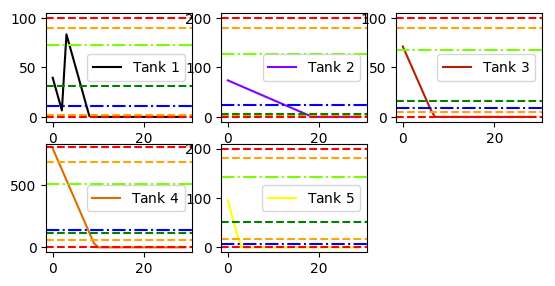

In [20]:
# THE REAL LEVELS (percentages 12h, 36h, ? h)

cmap = plt.get_cmap('gnuplot')
colors = [cmap(i) for i in np.linspace(0, 1, n)]
lvl_colors = ["Orange", "Green","Orange"]

tanks = test_toy_system.tanks

for i, color in enumerate(colors, start=1):
    plt.subplot(3,3, i)    

    plt.plot(tank_levels_array[i-1], color=color, label='Tank ${i}$'.format(i=i))
    
    plt.axhline(y= tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = "Red", linestyle = '--')
    for lvl_color, lvl in zip(lvl_colors, tanks[i-1].level_percentages):
        plt.axhline(y= lvl * tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = lvl_color, 
                    linestyle = '--')
    plt.axhline(y= 0, xmin=0, xmax=episode_length, hold=None, color = "Red", linestyle = '--')
    
    
    percentages = tanks[i-1].level_percentages           
    c = percentages[1]
    e = percentages[2]          
    d = ct.p0_GLOBAL*e+(1-ct.p0_GLOBAL)*c
    plt.axhline(y= d*tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = "lawngreen", 
                linestyle = '-.')

    plt.axhline(y= np.mean(tank_levels_array[i-1]), xmin=0, xmax=episode_length, hold=None, 
                color = "blue", linestyle = '-.')
  


    plt.legend(loc='best')
#plt.show()
plt.savefig(simulation_directory + '/tank-levels-sim' + f'{simulation_id}' + '.pdf')

### Test visualization

In [21]:
def visualize_simulation(states_file,
                        test_toy_system,
                        simulation_id,
                        simulation_directory):
    test_states = pd.read_table(states_file, sep = ",")
    test_states.head()


    cmap = plt.get_cmap('gnuplot')
    colors = [cmap(i) for i in np.linspace(0, 1, n)]
    lvl_colors = ["Orange", "Green","Orange"]

    tanks = test_toy_system.tanks

    for i, color in enumerate(colors, start=1):    
        plt.subplot(2,3,i)
        states = test_states['stock{}'.format(i-1)]
        plt.plot(test_states['step'],states, label = "Shop {}".format(i-1), color = "Black")
        plt.title("Shop {}".format(i-1))

        plt.axhline(y= tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = "Red", linestyle = '--')
        for lvl_color, lvl in zip(lvl_colors, tanks[i-1].level_percentages):
            plt.axhline(y= lvl * tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = lvl_color, 
                        linestyle = '--')
        plt.axhline(y= 0, xmin=0, xmax=episode_length, hold=None, color = "Red", linestyle = '--')


        percentages = tanks[i-1].level_percentages           
        c = percentages[1]
        e = percentages[2]          
        d = ct.p0_GLOBAL*e+(1-ct.p0_GLOBAL)*c
        plt.axhline(y= d*tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = "lawngreen", 
                    linestyle = '-.')

        plt.axhline(y= np.mean(states), xmin=0, xmax=episode_length, hold=None, 
                    color = "blue", linestyle = '-.')
        plt.xticks(range(0,episode_length+1,5))


    plt.subplot(2,3,6)
    plt.title("Legend")
    plt.axis('off')

    #plt.legend(bbox_to_anchor=(0.5 ,0.8), loc=2, borderaxespad=0.)
    plt.yticks([])
    plt.xticks([])

    patch1 = mpatches.Patch(color='red', label='Max/Min capacities', linestyle = '--', fill = False, linewidth = 2)
    patch2 = mpatches.Patch(color='orange', label='Max/Min levels', linestyle = '--', fill = False, linewidth = 2)
    patch3 = mpatches.Patch(color='green', label='Danger level', linestyle = '--', fill = False, linewidth = 2)
    patch4 = mpatches.Patch(color='lawngreen', label='Max reward level (M)', linestyle = '-.', fill = False, linewidth = 2)
    patch5 = mpatches.Patch(color='blue', label='Observed mean level', linestyle = '-.', fill = False, linewidth = 2)
    patch6 = mpatches.Patch(color='black', label='Current stock level', linestyle = '-', fill = False, linewidth = 2)


    plt.legend(handles=[patch1, patch2, patch3, patch4, patch5, patch6], loc = 'center')

    plt.tight_layout() 
    plt.savefig(simulation_directory + '/tank-levels-sim' + f'{simulation_id}' + '.pdf')
    plt.show()
    plt.close()


## Simulations

In [22]:
def test_simulation(simulation_id,
                   max_episodes,
                   n_episodes = 1):
    
    # Initialize directories and files
    
    simulation_directory = './simulations/simulation{}'.format(simulation_id)
    rewards_file = simulation_directory+'/discrewards'+ '/rewards-sim{}.csv'.format(simulation_id)
    states_file = simulation_directory+'/vis'+ '/states-sim{}.csv'.format(simulation_id) # for testing
    
    with open(states_file,'w') as f:
         np.savetxt(f, [["step", "stock0", "stock1", "stock2","stock3", "stock4"]], fmt="%s", delimiter=',') 

    # Initialize system
    episodes = max_episodes#100000

    tanks, trucks, graph, weights_matrix = initialize_test_system(seed =episodes+1)
    test_toy_system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)

    Q = ut.load_obj(simulation_directory + "/Q-dictionaries/Q-dict-sim" + f"{simulation_id}" + "-" + f"{episodes}")


    test_episodes = n_episodes
    episode_length =30
    test_freq = 1
    test_verbose = True

    test_visualization_steps = []
    test_rewards_list = []
    test_level_rewards_list = []
    test_transport_rewards_list = []
    test_trucks_sent_list = []
        
    test_Q(n_episodes = test_episodes, 
           episode_length = episode_length,
           system = test_toy_system,
           visualization_steps = test_visualization_steps, 
           rewards_list = test_rewards_list,
           level_rewards_list = test_level_rewards_list,
           transport_rewards_list = test_transport_rewards_list,
           trucks_sent_list = test_trucks_sent_list,
           freq = test_freq,
           test_verbose = test_verbose ,
           states_file = states_file, 
           Q = Q 
          )
            
    visualize_simulation(states_file,
                        test_toy_system,
                        simulation_id,
                        simulation_directory)   
    print("Total discounted rewards","Level rewards", "Transport rewards")
    print(sum(test_rewards_list)/n_episodes, sum(test_level_rewards_list)/n_episodes,sum(test_transport_rewards_list)/n_episodes )
    print("Average trucks sent: ", sum(test_trucks_sent_list)/n_episodes)
    
test_episodes = 10

### Deterministic consumption rates without transport/unload costs, 100K episodes 

Test episode: 1
Episode 1 t 0 -0.0009341 -0.0009341 0.0 5500
Episode 1 t 1 -116.1836147 -0.0006827 116.182932 0300
Episode 1 t 2 -162.0472994 3.16e-05 162.047331 1400
Episode 1 t 3 -56.3373433 2.87e-05 56.337372 4500
Episode 1 t 4 0.0001636 0.0001636 0.0 5500
Episode 1 t 5 -163.1300076 0.0007344 163.130742 2300
Episode 1 t 6 -11.5563485 3.55e-05 11.556384 0500
Episode 1 t 7 0.0008252 0.0008252 0.0 5500
Episode 1 t 8 -160.9638928 2.72e-05 160.96392 3400
Episode 1 t 9 0.0005864 0.0005864 0.0 5500
Episode 1 t 10 -116.1829086 2.34e-05 116.182932 0400
Episode 1 t 11 -160.9638229 9.71e-05 160.96392 3300
Episode 1 t 12 -163.1307167 2.53e-05 163.130742 2300
Episode 1 t 13 0.00045 0.00045 0.0 5500
Episode 1 t 14 -116.1822929 0.0006391 116.182932 0300
Episode 1 t 15 -160.9638905 2.95e-05 160.96392 3400
Episode 1 t 16 -160.9638993 2.07e-05 160.96392 4300
Episode 1 t 17 0.0003097 0.0003097 0.0 5500
Episode 1 t 18 -120.2070112 1.88e-05 120.20703 0200
Episode 1 t 19 -160.9638987 2.13e-05 160.96392 3

Episode 6 t 16 0.0016069 0.0016069 0.0 5500
Episode 6 t 17 -116.1840106 -0.0010786 116.182932 0400
Episode 6 t 18 -160.963903 1.7e-05 160.96392 3300
Episode 6 t 19 -163.1305945 0.0001475 163.130742 2300
Episode 6 t 20 -160.9633511 0.0005689 160.96392 3400
Episode 6 t 21 -116.1828985 3.35e-05 116.182932 0300
Episode 6 t 22 2.12e-05 2.12e-05 0.0 5500
Episode 6 t 23 -160.9639 2e-05 160.96392 4300
Episode 6 t 24 0.0004155 0.0004155 0.0 5500
Episode 6 t 25 -116.1826697 0.0002623 116.182932 0300
Episode 6 t 26 -163.1302097 0.0005323 163.130742 2400
Episode 6 t 27 -160.9638962 2.38e-05 160.96392 3300
Episode 6 t 28 -160.9636341 0.0002859 160.96392 3300
Episode 6 t 29 -116.1829086 2.34e-05 116.182932 0400
Test episode: 7
Episode 7 t 0 2.47e-05 2.47e-05 0.0 5500
Episode 7 t 1 -160.9638943 2.57e-05 160.96392 3300
Episode 7 t 2 0.0005759 0.0005759 0.0 5500
Episode 7 t 3 -162.0470893 0.0002417 162.047331 1400
Episode 7 t 4 -116.1829051 2.69e-05 116.182932 0300
Episode 7 t 5 2.05e-05 2.05e-05 0.0 5

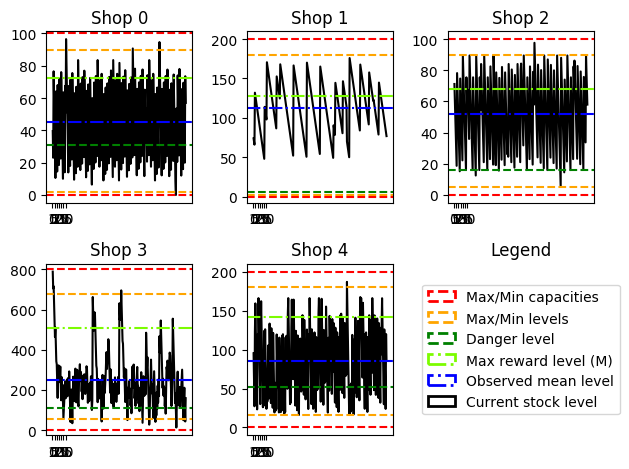

Total discounted rewards Level rewards Transport rewards
-860.4459408758224 -0.09408424925888197 3036.6720554999997
Average trucks sent:  41.9


In [23]:
test_simulation(simulation_id= 16, max_episodes = 100000,n_episodes = test_episodes)


### Deterministic consumption rates WITH transport/unload costs, 100K episodes 

Test episode: 1
Episode 1 t 0 -0.0009341 -0.0009341 0.0 5500
Episode 1 t 1 -116.1836147 -0.0006827 116.182932 0300
Episode 1 t 2 -164.9880021 1.59e-05 164.988018 4200
Episode 1 t 3 0.0006521 0.0006521 0.0 5500
Episode 1 t 4 -56.3372117 0.0001603 56.337372 4500
Episode 1 t 5 0.0013004 0.0013004 0.0 5500
Episode 1 t 6 -163.9759558 -0.9999868 162.975969 4100
Episode 1 t 7 -116.1823942 0.0005378 116.182932 0300
Episode 1 t 8 -160.9639053 1.47e-05 160.96392 4300
Episode 1 t 9 -104.6257093 0.0008387 104.626548 5300
Episode 1 t 10 -116.1819497 0.0009823 116.182932 0400
Episode 1 t 11 -58.5041646 2.94e-05 58.504194 2500
Episode 1 t 12 -160.9638976 2.24e-05 160.96392 3400
Episode 1 t 13 0.000246 0.000246 0.0 5500
Episode 1 t 14 -116.1829072 2.48e-05 116.182932 0300
Episode 1 t 15 1.82e-05 1.82e-05 0.0 5500
Episode 1 t 16 -163.1301141 0.0006279 163.130742 2300
Episode 1 t 17 -160.9638121 0.0001079 160.96392 4300
Episode 1 t 18 0.0012301 0.0012301 0.0 5500
Episode 1 t 19 -116.1839276 -0.0009956 1

Episode 6 t 17 -116.1842794 -0.0013474 116.182932 0400
Episode 6 t 18 -160.9639018 1.82e-05 160.96392 3300
Episode 6 t 19 -163.1307299 1.21e-05 163.130742 2300
Episode 6 t 20 0.001358 0.001358 0.0 5500
Episode 6 t 21 -116.1845692 -0.0016372 116.182932 0400
Episode 6 t 22 -160.9638976 2.24e-05 160.96392 3300
Episode 6 t 23 -160.9638988 2.12e-05 160.96392 4300
Episode 6 t 24 -160.9634982 0.0004218 160.96392 3300
Episode 6 t 25 -11.5563657 1.83e-05 11.556384 0500
Episode 6 t 26 -58.5032661 0.0009279 58.504194 2500
Episode 6 t 27 -160.9639028 1.72e-05 160.96392 4300
Episode 6 t 28 -160.962779 0.001141 160.96392 3300
Episode 6 t 29 -162.9751224 0.0008466 162.975969 4100
Test episode: 7
Episode 7 t 0 2.47e-05 2.47e-05 0.0 5500
Episode 7 t 1 2.07e-05 2.07e-05 0.0 5500
Episode 7 t 2 -160.9633441 0.0005759 160.96392 3300
Episode 7 t 3 -56.3371382 0.0002338 56.337372 4500
Episode 7 t 4 -116.1824132 0.0005188 116.182932 0300
Episode 7 t 5 -56.3373538 1.82e-05 56.337372 4500
Episode 7 t 6 -104.626

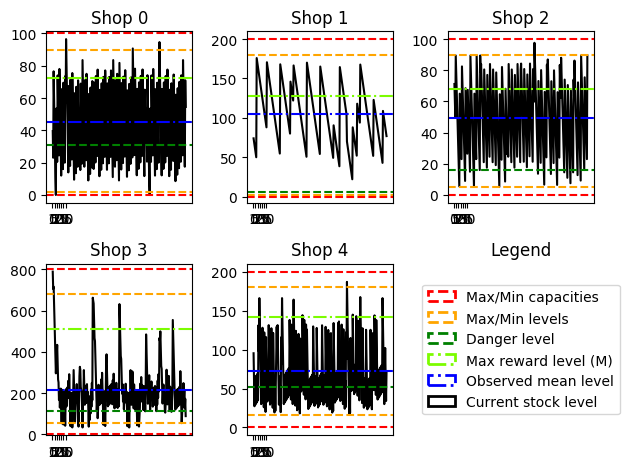

Total discounted rewards Level rewards Transport rewards
-812.4046531031147 -0.1914246914431194 2990.0441097000003
Average trucks sent:  41.7


In [24]:
test_simulation(simulation_id= 17, max_episodes = 100000, n_episodes = test_episodes)

Test episode: 1
Episode 1 t 0 -0.0009341 -0.0009341 0.0 5500
Episode 1 t 1 -116.1836147 -0.0006827 116.182932 0300
Episode 1 t 2 -162.0472994 3.16e-05 162.047331 1400
Episode 1 t 3 2.75e-05 2.75e-05 0.0 5500
Episode 1 t 4 0.0001558 0.0001558 0.0 5500
Episode 1 t 5 -58.5026129 0.0015811 58.504194 2500
Episode 1 t 6 -116.1828931 3.89e-05 116.182932 0400
Episode 1 t 7 2.67e-05 2.67e-05 0.0 5500
Episode 1 t 8 9.13e-05 9.13e-05 0.0 5500
Episode 1 t 9 -160.9633354 0.0005846 160.96392 4300
Episode 1 t 10 -116.1828897 4.23e-05 116.182932 0300
Episode 1 t 11 0.0010502 0.0010502 0.0 5500
Episode 1 t 12 -160.9649583 -0.0010383 160.96392 4300
Episode 1 t 13 -163.1293837 0.0013583 163.130742 2300
Episode 1 t 14 -116.1829005 3.15e-05 116.182932 0400
Episode 1 t 15 -104.6265255 2.25e-05 104.626548 5300
Episode 1 t 16 -104.6264018 0.0001462 104.626548 5300
Episode 1 t 17 -56.3370693 0.0003027 56.337372 4500
Episode 1 t 18 -33.016979 0.001261 33.01824 0000
Episode 1 t 19 -160.9749451 -0.0110251 160.963

Episode 6 t 15 -160.963787 0.000133 160.96392 4300
Episode 6 t 16 -104.6257713 0.0007767 104.626548 5300
Episode 6 t 17 -116.1829027 2.93e-05 116.182932 0400
Episode 6 t 18 -104.6265263 2.17e-05 104.626548 5300
Episode 6 t 19 -58.5041817 1.23e-05 58.504194 2500
Episode 6 t 20 -104.6257443 0.0008037 104.626548 5300
Episode 6 t 21 -105.626016 -0.999468 104.626548 5400
Episode 6 t 22 -116.1829076 2.44e-05 116.182932 0300
Episode 6 t 23 -104.6265325 1.55e-05 104.626548 5300
Episode 6 t 24 -104.6257626 0.0007854 104.626548 5300
Episode 6 t 25 -116.1829077 2.43e-05 116.182932 0400
Episode 6 t 26 -163.1307202 2.18e-05 163.130742 2300
Episode 6 t 27 -56.3373539 1.81e-05 56.337372 3500
Episode 6 t 28 -104.6257299 0.0008181 104.626548 5300
Episode 6 t 29 -116.1829067 2.53e-05 116.182932 0400
Test episode: 7
Episode 7 t 0 -56.3373456 2.64e-05 56.337372 3500
Episode 7 t 1 2.24e-05 2.24e-05 0.0 5500
Episode 7 t 2 -56.3367976 0.0005744 56.337372 3500
Episode 7 t 3 -160.9636844 0.0002356 160.96392 43

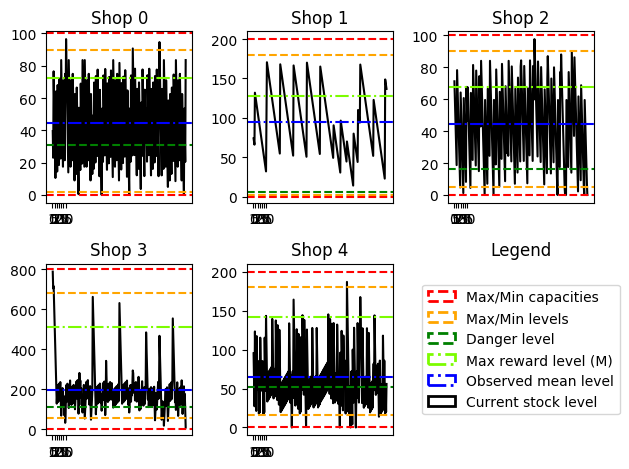

Total discounted rewards Level rewards Transport rewards
-761.531890996982 -1.6161399313526847 2914.5819539999998
Average trucks sent:  39.6


In [25]:
test_simulation(simulation_id= 18, max_episodes = 100000, n_episodes = test_episodes)

Test episode: 1
Episode 1 t 0 -0.0009341 -0.0009341 0.0 5500
Episode 1 t 1 0.001546 0.001546 0.0 5500
Episode 1 t 2 -22.4618348 -0.9999788 21.461856 5000
Episode 1 t 3 -0.9999759 -0.9999759 0.0 5500
Episode 1 t 4 -0.9999844 -0.9999844 0.0 5500
Episode 1 t 5 -0.9992832 -0.9992832 0.0 5500
Episode 1 t 6 -1.999529 -1.999529 0.0 5500
Episode 1 t 7 -2.0021514 -2.0021514 0.0 5500
Episode 1 t 8 -3.0017075 -3.0017075 0.0 5500
Episode 1 t 9 -3.9999977 -3.9999977 0.0 5500
Episode 1 t 10 -3.999998 -3.999998 0.0 5500
Episode 1 t 11 -3.9999984 -3.9999984 0.0 5500
Episode 1 t 12 -3.9999987 -3.9999987 0.0 5500
Episode 1 t 13 -3.999999 -3.999999 0.0 5500
Episode 1 t 14 -3.9999993 -3.9999993 0.0 5500
Episode 1 t 15 -3.9999997 -3.9999997 0.0 5500
Episode 1 t 16 -3.9999859 -3.9999859 0.0 5500
Episode 1 t 17 -4.0010226 -4.0010226 0.0 5500
Episode 1 t 18 -5.0 -5.0 0.0 5500
Episode 1 t 19 -5.0 -5.0 0.0 5500
Episode 1 t 20 -5.0 -5.0 0.0 5500
Episode 1 t 21 -5.0 -5.0 0.0 5500
Episode 1 t 22 -5.0 -5.0 0.0 5500

Episode 7 t 2 -0.0007162 -0.0007162 0.0 5500
Episode 7 t 3 -1.9997691 -1.9997691 0.0 5500
Episode 7 t 4 -1.9992025 -1.9992025 0.0 5500
Episode 7 t 5 -2.9999914 -2.9999914 0.0 5500
Episode 7 t 6 -2.9999938 -2.9999938 0.0 5500
Episode 7 t 7 -2.9997804 -2.9997804 0.0 5500
Episode 7 t 8 -3.0015764 -3.0015764 0.0 5500
Episode 7 t 9 -3.9999963 -3.9999963 0.0 5500
Episode 7 t 10 -3.9999967 -3.9999967 0.0 5500
Episode 7 t 11 -3.999997 -3.999997 0.0 5500
Episode 7 t 12 -3.9999973 -3.9999973 0.0 5500
Episode 7 t 13 -3.9999977 -3.9999977 0.0 5500
Episode 7 t 14 -3.999998 -3.999998 0.0 5500
Episode 7 t 15 -3.9999983 -3.9999983 0.0 5500
Episode 7 t 16 -3.9999986 -3.9999986 0.0 5500
Episode 7 t 17 -3.999999 -3.999999 0.0 5500
Episode 7 t 18 -3.9999993 -3.9999993 0.0 5500
Episode 7 t 19 -3.9999996 -3.9999996 0.0 5500
Episode 7 t 20 -4.0 -4.0 0.0 5500
Episode 7 t 21 -3.9991202 -3.9991202 0.0 5500
Episode 7 t 22 -5.0 -5.0 0.0 5500
Episode 7 t 23 -5.0 -5.0 0.0 5500
Episode 7 t 24 -5.0 -5.0 0.0 5500
Epis

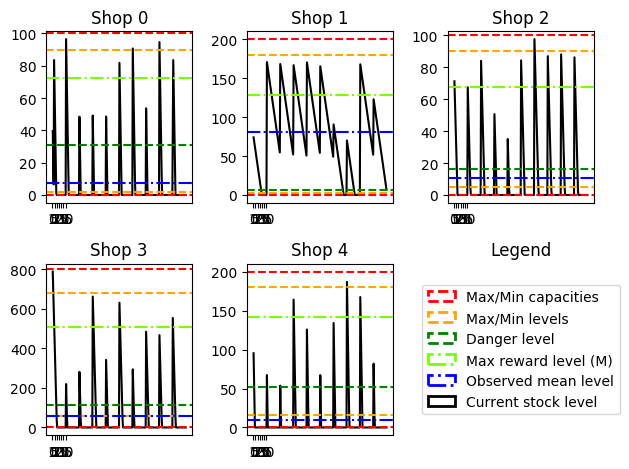

Total discounted rewards Level rewards Transport rewards
-26.8143942451487 -104.84800499316262 3.301824
Average trucks sent:  0.2


In [29]:
test_simulation(simulation_id= 21, max_episodes = 100000, n_episodes = test_episodes)

### Stochastic consumption rates without transport/unload costs, 100K episodes 

Test episode: 1
Episode 1 t 0 -0.0009341 -0.0009341 0.0 5500
Episode 1 t 1 -116.1829035 2.85e-05 116.182932 0400
Episode 1 t 2 -57.4207458 3.72e-05 57.420783 1500
Episode 1 t 3 2.83e-05 2.83e-05 0.0 5500
Episode 1 t 4 -56.3372108 0.0001612 56.337372 4500
Episode 1 t 5 -163.13001 0.000732 163.130742 2300
Episode 1 t 6 -116.1828958 3.62e-05 116.182932 0400
Episode 1 t 7 3.3e-05 3.3e-05 0.0 5500
Episode 1 t 8 2.07e-05 2.07e-05 0.0 5500
Episode 1 t 9 -56.3367904 0.0005816 56.337372 3500
Episode 1 t 10 -116.1823002 0.0006318 116.182932 0300
Episode 1 t 11 -160.9638311 8.89e-05 160.96392 4300
Episode 1 t 12 -163.1307213 2.07e-05 163.130742 2400
Episode 1 t 13 -160.9634619 0.0004581 160.96392 3300
Episode 1 t 14 -116.1828985 3.35e-05 116.182932 0300
Episode 1 t 15 -104.626524 2.4e-05 104.626548 5400
Episode 1 t 16 2.08e-05 2.08e-05 0.0 5500
Episode 1 t 17 -160.9636128 0.0003072 160.96392 3300
Episode 1 t 18 -163.1298663 0.0008757 163.130742 2300
Episode 1 t 19 -116.1829037 2.83e-05 116.182932

Episode 6 t 12 -116.1824117 0.0005203 116.182932 0300
Episode 6 t 13 -163.1307101 3.19e-05 163.130742 2400
Episode 6 t 14 -160.9638892 3.08e-05 160.96392 3300
Episode 6 t 15 -56.337233 0.000139 56.337372 4500
Episode 6 t 16 0.0006997 0.0006997 0.0 5500
Episode 6 t 17 -116.1829099 2.21e-05 116.182932 0300
Episode 6 t 18 -160.9638991 2.09e-05 160.96392 4300
Episode 6 t 19 -163.1307272 1.48e-05 163.130742 2300
Episode 6 t 20 -162.0467688 0.0005622 162.047331 1400
Episode 6 t 21 -116.1828959 3.61e-05 116.182932 0300
Episode 6 t 22 2.49e-05 2.49e-05 0.0 5500
Episode 6 t 23 -160.9638951 2.49e-05 160.96392 4300
Episode 6 t 24 -104.6261233 0.0004247 104.626548 5300
Episode 6 t 25 -116.1829063 2.57e-05 116.182932 0300
Episode 6 t 26 -58.5035048 0.0006892 58.504194 2500
Episode 6 t 27 -160.9638894 3.06e-05 160.96392 3400
Episode 6 t 28 -160.9636262 0.0002938 160.96392 3300
Episode 6 t 29 -11.5563579 2.61e-05 11.556384 0500
Test episode: 7
Episode 7 t 0 -160.9638903 2.97e-05 160.96392 3300
Episod

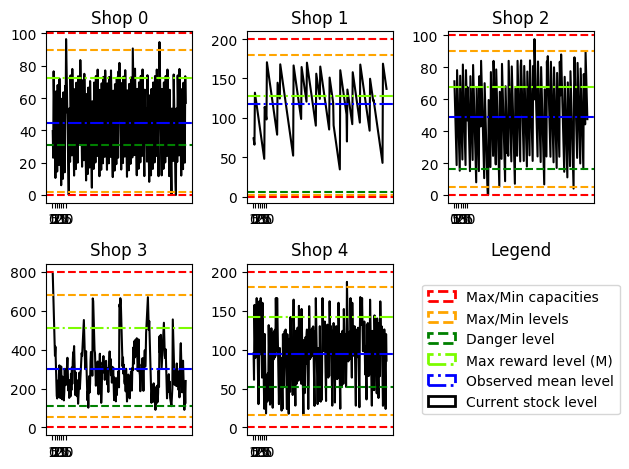

Total discounted rewards Level rewards Transport rewards
-898.430829556973 -0.49288794015939547 3052.6446291
Average trucks sent:  42.7


In [26]:
test_simulation(simulation_id= 14, max_episodes = 100000,n_episodes = test_episodes)

### Stochastic consumption rates WITH transport/unload costs, 100K episodes 


Test episode: 1
Episode 1 t 0 -0.0009341 -0.0009341 0.0 5500
Episode 1 t 1 -116.1836147 -0.0006827 116.182932 0300
Episode 1 t 2 -56.3373517 2.03e-05 56.337372 4500
Episode 1 t 3 -56.3373491 2.29e-05 56.337372 4500
Episode 1 t 4 -56.337213 0.000159 56.337372 4500
Episode 1 t 5 -58.5034675 0.0007265 58.504194 2500
Episode 1 t 6 -116.1829011 3.09e-05 116.182932 0300
Episode 1 t 7 0.0005417 0.0005417 0.0 5500
Episode 1 t 8 -116.1829075 2.45e-05 116.182932 0400
Episode 1 t 9 -56.3373489 2.31e-05 56.337372 3500
Episode 1 t 10 -162.9759485 2.05e-05 162.975969 4100
Episode 1 t 11 -104.6264635 8.45e-05 104.626548 5300
Episode 1 t 12 -160.9644847 -0.0005647 160.96392 4300
Episode 1 t 13 -120.2070073 2.27e-05 120.20703 0200
Episode 1 t 14 -56.3373519 2.01e-05 56.337372 3500
Episode 1 t 15 -56.3367757 0.0005963 56.337372 3500
Episode 1 t 16 -160.9635723 0.0003477 160.96392 4300
Episode 1 t 17 -116.1823842 0.0005478 116.182932 0300
Episode 1 t 18 -56.3373485 2.35e-05 56.337372 4500
Episode 1 t 19 

Episode 6 t 12 -11.5558672 0.0005168 11.556384 0500
Episode 6 t 13 -163.1319035 -0.0011615 163.130742 2400
Episode 6 t 14 -160.9638927 2.73e-05 160.96392 3300
Episode 6 t 15 -116.1829092 2.28e-05 116.182932 0300
Episode 6 t 16 -56.3373446 2.74e-05 56.337372 4500
Episode 6 t 17 -162.0473165 1.45e-05 162.047331 1300
Episode 6 t 18 -160.9632981 0.0006219 160.96392 3300
Episode 6 t 19 -163.1302587 0.0004833 163.130742 2400
Episode 6 t 20 -11.5563569 2.71e-05 11.556384 0500
Episode 6 t 21 -160.9638891 3.09e-05 160.96392 4300
Episode 6 t 22 -160.9638952 2.48e-05 160.96392 3300
Episode 6 t 23 -56.3370207 0.0003513 56.337372 4500
Episode 6 t 24 -116.1829037 2.83e-05 116.182932 0300
Episode 6 t 25 -56.3373449 2.71e-05 56.337372 4500
Episode 6 t 26 -163.1307178 2.42e-05 163.130742 2300
Episode 6 t 27 -56.3371545 0.0002175 56.337372 4500
Episode 6 t 28 -160.9631352 0.0007848 160.96392 3300
Episode 6 t 29 -116.1829043 2.77e-05 116.182932 0400
Test episode: 7
Episode 7 t 0 -57.4207604 2.26e-05 57.4

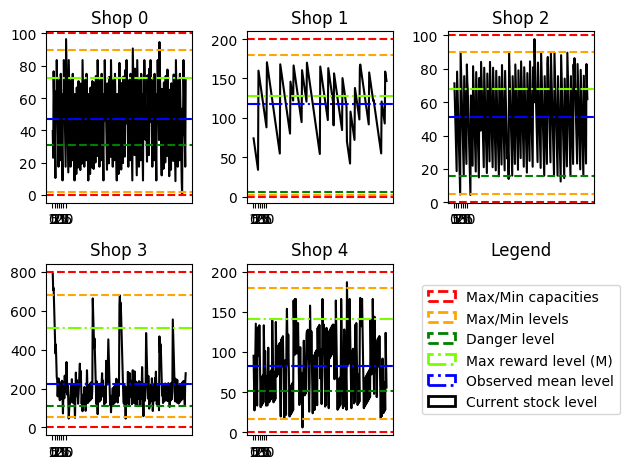

Total discounted rewards Level rewards Transport rewards
-838.4548292972755 -0.09306716403222177 3028.4639274
Average trucks sent:  43.6


In [27]:
test_simulation(simulation_id= 19, max_episodes = 100000,n_episodes = test_episodes)

Test episode: 1
Episode 1 t 0 -0.0009341 -0.0009341 0.0 5500
Episode 1 t 1 -116.1836147 -0.0006827 116.182932 0300
Episode 1 t 2 -56.3373517 2.03e-05 56.337372 4500
Episode 1 t 3 0.0006497 0.0006497 0.0 5500
Episode 1 t 4 -56.3372208 0.0001512 56.337372 4500
Episode 1 t 5 -58.5028964 0.0012976 58.504194 2500
Episode 1 t 6 -57.3373524 -0.9999804 56.337372 4500
Episode 1 t 7 -11.5558441 0.0005399 11.556384 0500
Episode 1 t 8 -160.9639044 1.56e-05 160.96392 4300
Episode 1 t 9 -57.419942 0.000841 57.420783 1500
Episode 1 t 10 -116.1825117 0.0004203 116.182932 0400
Episode 1 t 11 -104.6264568 9.12e-05 104.626548 5300
Episode 1 t 12 -163.1307226 1.94e-05 163.130742 2300
Episode 1 t 13 -104.6256728 0.0008752 104.626548 5300
Episode 1 t 14 -116.1829026 2.94e-05 116.182932 0400
Episode 1 t 15 -104.6265229 2.51e-05 104.626548 5300
Episode 1 t 16 -104.6265319 1.61e-05 104.626548 5300
Episode 1 t 17 0.0008926 0.0008926 0.0 5500
Episode 1 t 18 -104.6247046 0.0018434 104.626548 5400
Episode 1 t 19 -

Episode 6 t 11 -56.3371069 0.0002651 56.337372 4500
Episode 6 t 12 -116.1827233 0.0002087 116.182932 0300
Episode 6 t 13 -163.1305962 0.0001458 163.130742 2400
Episode 6 t 14 -104.6265197 2.83e-05 104.626548 5300
Episode 6 t 15 -104.6264161 0.0001319 104.626548 5300
Episode 6 t 16 -104.6254936 0.0010544 104.626548 5300
Episode 6 t 17 -116.1829025 2.95e-05 116.182932 0400
Episode 6 t 18 -104.6265275 2.05e-05 104.626548 5300
Episode 6 t 19 -58.5041828 1.12e-05 58.504194 2500
Episode 6 t 20 -104.6254665 0.0010815 104.626548 5300
Episode 6 t 21 -77.7987001 0.0005279 77.799228 4000
Episode 6 t 22 -104.626058 0.00049 104.626548 5300
Episode 6 t 23 -160.9639013 1.87e-05 160.96392 4300
Episode 6 t 24 -104.6261239 0.0004241 104.626548 5300
Episode 6 t 25 -56.3368979 0.0004741 56.337372 4500
Episode 6 t 26 -116.1820883 0.0008437 116.182932 0300
Episode 6 t 27 -163.0470848 -0.9997538 162.047331 1400
Episode 6 t 28 -163.1307162 2.58e-05 163.130742 2300
Episode 6 t 29 -104.6262013 0.0003467 104.626

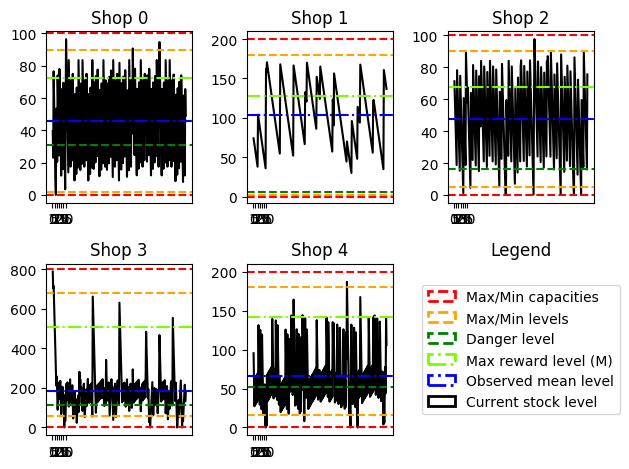

Total discounted rewards Level rewards Transport rewards
-767.1987049145624 -1.4151731385258475 2949.5400155999996
Average trucks sent:  39.8


In [28]:
test_simulation(simulation_id= 20, max_episodes = 100000,n_episodes = test_episodes)